# Challenge 1
### Categorizing our content & developing strategy
------------------

**Problem Statement:** Analyze the given dataset and answer the following questions:

1. What are the major shortcomings of using RAKE for keyword extraction?  
2. How would you improve it to achieve better search results? </br>
3. In addition to improving search, we are also interested in improving personalized
recommendations that can be found in the “For You” section on the Discover screen.
Which data points would you extract from books in blinks or in general from user and
tracking data to be used in recommendation algorithms and why? Please list the data
points in an order that is in line with our approach of maximizing value in an agile way. </br>
4. By looking at the data we have around our content (assume we extracted the data points
you listed in the previous question) and the mobile tracking data, which recommender
system method would you employ and why?

## Methodology
------------------

In order to analyse and understand the dataset, we'll categorize the analysis in mainly two parts:
1. *Univariate analysis:* Helps in exploring features individually to detect anomalies (outliers, errors) etc.
2. *Multivariate analysis:* Helps in exploring the inter-impact of features across multiple variables.

Since, the questions revolve around analyzing category specific behaviour (search / discover), we'll try to categorize the variable distribution by these two variables in order to determine category specific behaviour.

**Note:** Bivariate analysis is also widely used method in exploring behaviour of two variables.


## Summary : Dataset
-----------------------

1. The given dataset(s): 
    * discover_events: represents a small sample of actual blinkist tracking data.
    * book_json: represents meta information for the books (blinks) available at blinkist.
2. The dataset given is for one week from `2018-11-07` to `2018-11-16`.
3. The tracking data has 924256 entries and 12 features.
4. 70% of the events in the given dataset belong to search. Search looks like an essential component for blinkist for content discovery.

**Note:** The data dictionary doesn't not contain information for all the given features.

In [2]:
### Load libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# read the data
discover_events = pd.read_csv('discover_events.csv', parse_dates=['dim_date_id','event_timestamp','arrival_timestamp'])

In [4]:
# missing values
discover_events.isna().sum(axis=0) / discover_events.shape[0]

dim_date_id          0.000000
func_sha1            0.002534
event_type           0.000000
category             0.000000
depth                0.028149
action               0.000000
content              0.163694
screen_url           0.028149
screenurl_params     0.028149
event_timestamp      0.000000
arrival_timestamp    0.000000
session_id           0.000819
dtype: float64

We see that `content` has 16% missing values. Let's look at the missing values distribution category-wise.

In [5]:
discover_events.set_index('category').isna().sum(level=0)

,dim_date_id,func_sha1,event_type,depth,action,content,screen_url,screenurl_params,event_timestamp,arrival_timestamp,session_id
category,,,,,,,,,,,
search,0.0,2342.0,0.0,26017.0,0.0,151295.0,26017.0,26017.0,0.0,0.0,757.0
flex-discover,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Interesting! We see that all the missing values are coming from search category. In further analysis, we discovered that `content` variable ends up being missing because of the following search events (search attempt events): <br/>

|         event-type      |frequency | 
--------------------------|----------|
SearchViewedSimplified    |     81715 
SearchDismissedSimplified   |   43359
search-2-trigger            | 11591
search-3-book-open          |  5473
search-1-open               |  3775
search-4-clear              |  2227
search-2-book-add           |  1660
search-5-dismiss            |  1291
SearchClearedSimplified     |   138
SearchTriggeredSimplified   |    66


## Univariate Analysis

In this section, we'll analyse some of the variable which seems influential in the given problem discovery.

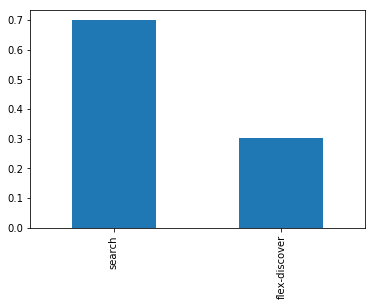

In [6]:
discover_events['category'].value_counts(normalize=True).plot(kind='bar')

We see that the data contains almost 70% `search` events. It seems like search is a quite an important channel for blinkist and the user for content discovery. 

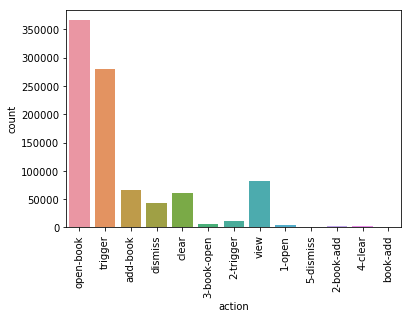

In [7]:
sns.countplot(x = 'action', data=discover_events)
_, _ = plt.xticks(rotation=90)

In [8]:
discover_events['action'].value_counts(normalize=True)

open-book      0.396074
trigger        0.302783
view           0.088412
add-book       0.072103
clear          0.065127
dismiss        0.046912
2-trigger      0.012541
3-book-open    0.005922
1-open         0.004084
4-clear        0.002410
2-book-add     0.001796
5-dismiss      0.001397
book-add       0.000439
Name: action, dtype: float64

In the given data, we see that 39% of the events result in `open-book` event. It's hard to interpret this number without any context. Let's look at it further in multi-variate analysis. Similary, we can plot `event-type` and check its distribution.

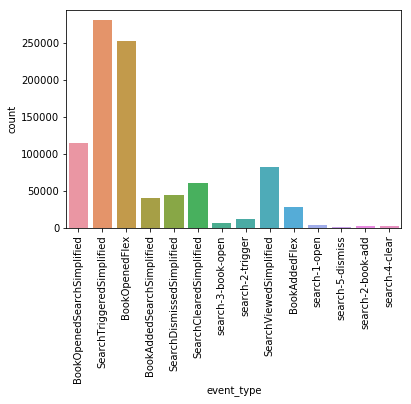

In [9]:
sns.countplot(x = 'event_type', data=discover_events)
_, _ = plt.xticks(rotation=90)

## Multivariate analysis


Let's create two features to explore variables. Even though, there is not much information given about `arrival_timestamp` but lets see if we see any anomaly in the distribution.

In [31]:
# weekday
discover_events['weekday'] = discover_events['dim_date_id'].dt.day_name()

In [29]:
# time difference in minutes
discover_events['time_diff'] = abs((discover_events['arrival_timestamp'] 
                                      - discover_events['event_timestamp']).dt.total_seconds()).astype(int) / 60

### `action` distribution by category

/anaconda3/envs/bunnies/lib/python2.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


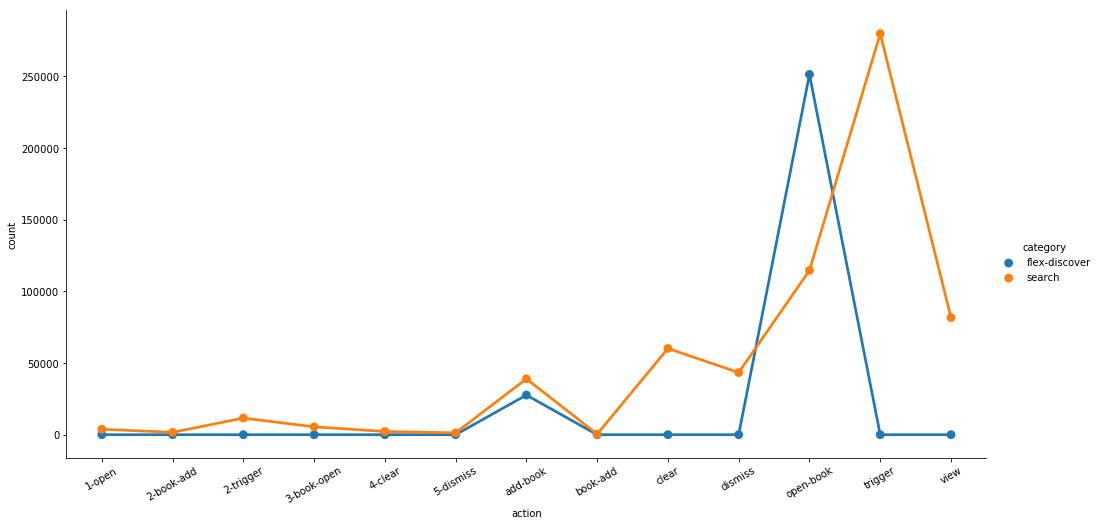

In [39]:
# count action events for each category
discover_events['flag']= 1

action_by_cat = (pd.pivot_table(discover_events, 
               values = 'flag',
               index= ['action'],
               columns = ['category'],
               aggfunc='sum',
               fill_value=0)
               .rename_axis(None, axis=1)
               .reset_index())

action_by_cat = (action_by_cat
                 .set_index('action')
                 .unstack()
                 .reset_index())
action_by_cat.columns = ['category','action','count']

g = sns.catplot(x="action", 
            y="count", 
            hue="category", 
            kind="point", 
            data=action_by_cat,
            size=7, aspect=2)
g.set_xticklabels(rotation=30)

We notice the following observations:

1. Even though, search comprises of 70% events in the given data, it's `open-book` rate is almost half of `flex-discover` channel. 
2. However, for search, the `add-book` rate is higher than `flex-discover`. It means that, even though users are adding books from search, but they are not opening it to read. :(

Let's see if this behaviour is any different if we group-by weekdays. This analysis would make more sense if we have more week-wise data.

### `action` distribution by weekday by category

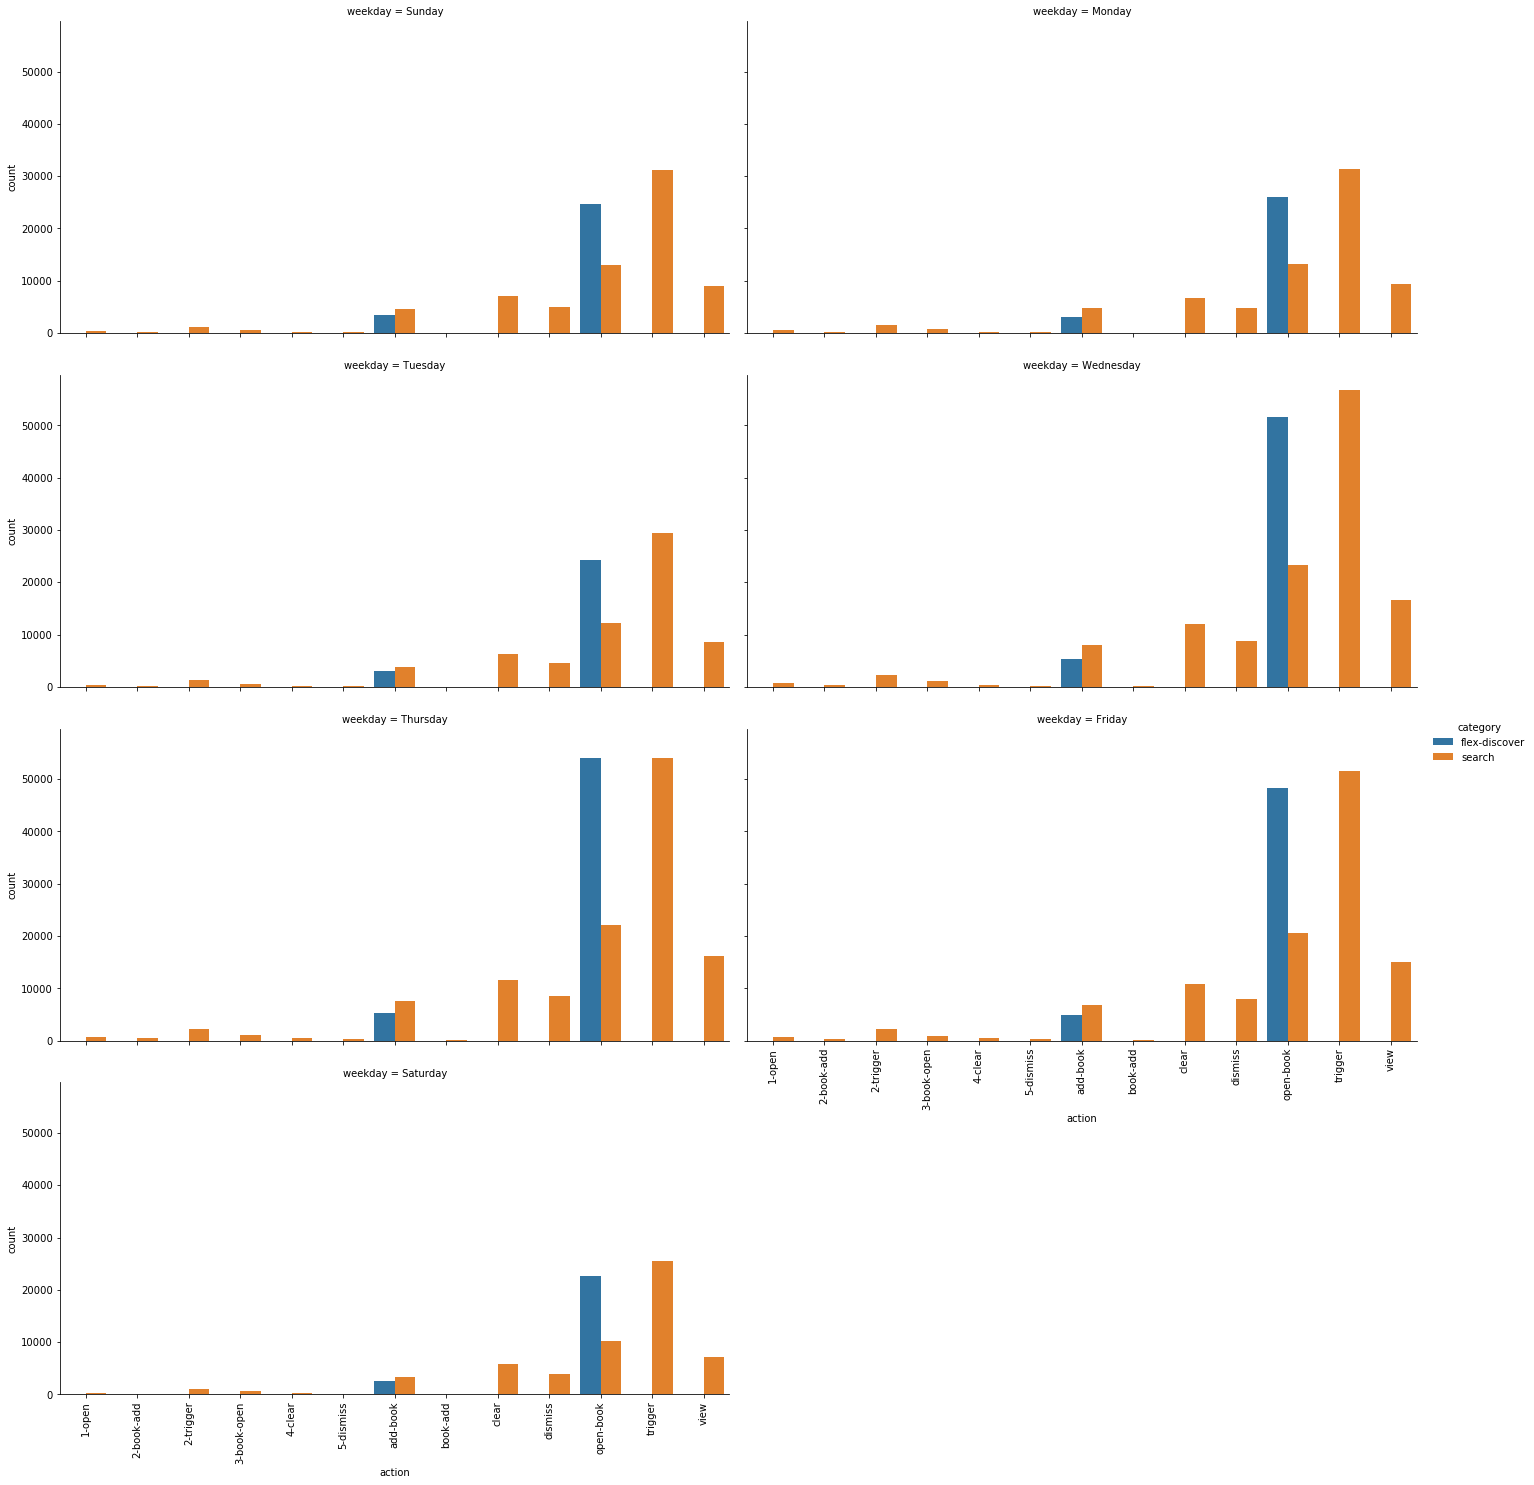

In [33]:
events_by_cat_day = (pd.pivot_table(discover_events, 
               values = 'flag',
               index= ['weekday','action'],
               columns = ['category'],
               aggfunc='sum',
               fill_value=0)
               .rename_axis(None, axis=1)
               .reset_index())

events_by_cat_day = events_by_cat_day.set_index(['weekday','action']).stack().reset_index()
events_by_cat_day.columns = ['weekday','action','category','count']

g = sns.catplot(x="action", 
            y="count", 
            hue="category", 
            col = "weekday",
            kind="bar", 
            data=events_by_cat_day,
            height=5, 
            aspect=2,
            col_wrap=2,
            col_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"])
g.set_xticklabels(rotation=90)

We don't observe any significant difference in `add-book` and `open-book` events than what we saw above. 

### `event` distribution by category

Since each event is defined category-wise, here we just see if the trackings are correct, we see as expected trend. 

/anaconda3/envs/bunnies/lib/python2.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


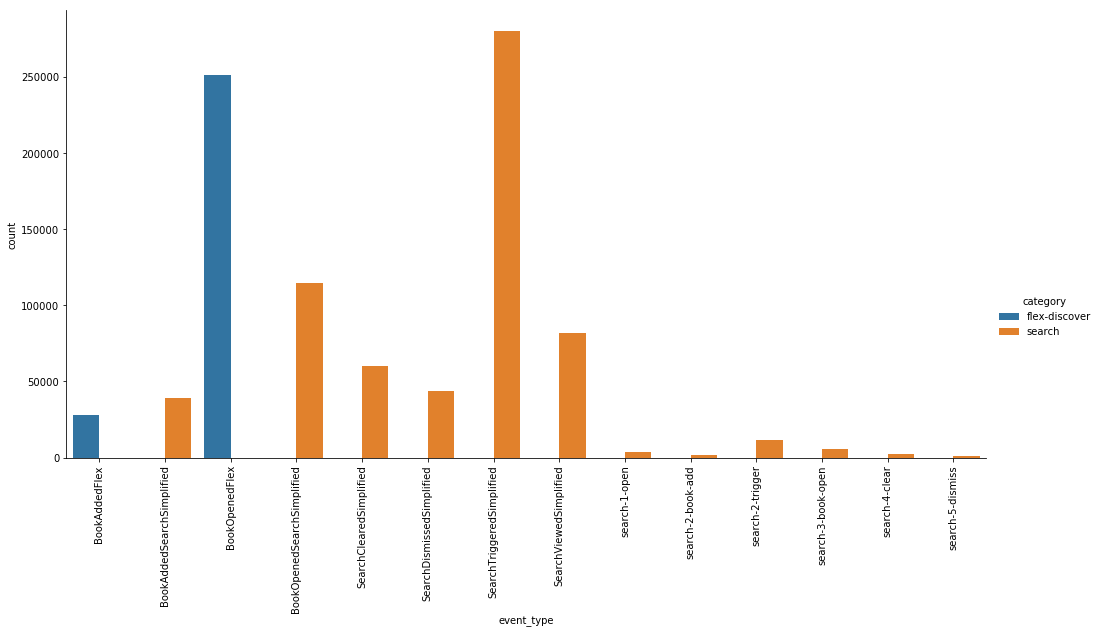

In [34]:
discover_events['flag']= 1
events_by_cat = (pd.pivot_table(discover_events, 
               values = 'flag',
               index= ['event_type'],
               columns = ['category'],
               aggfunc='sum',
               fill_value=0)
               .rename_axis(None, axis=1)
               .reset_index())

events_by_cat = (events_by_cat
                 .set_index('event_type')
                 .unstack()
                 .reset_index())
events_by_cat.columns = ['category','event_type','count']

g = sns.catplot(x="event_type", 
            y="count", 
            hue="category", 
            kind="bar", 
            data=events_by_cat,
            size=7, aspect=2)
g.set_xticklabels(rotation=90)

### `time-diff` impact by category

Let's see if the time-diff feature has any impact on search / discover behaviour of users. We are going to plot the average time-diff between categories.

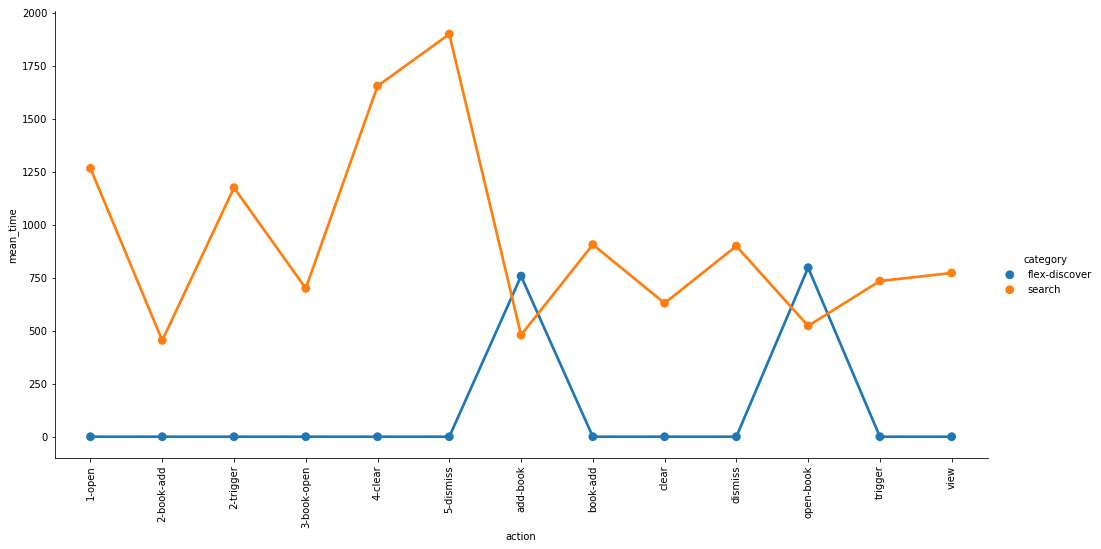

In [40]:
action_time_by_cat = (pd.pivot_table(discover_events, 
               values = 'time_diff',
               index= ['action'],
               columns = ['category'],
               aggfunc='mean',
               fill_value=0)
               .rename_axis(None, axis=1)
               .reset_index())

action_time_by_cat = (action_time_by_cat
                 .set_index('action')
                 .unstack()
                 .reset_index())
action_time_by_cat.columns = ['category','action','mean_time']

g = sns.catplot(x="action", 
            y="mean_time", 
            hue="category", 
            kind="point", 
            data=action_time_by_cat,
            height=7, aspect=2)
g.set_xticklabels(rotation=90)

We learn the following things:
1. The average time-diff for `flex-discover` is higher for `add-book` and `open-book` events.
2. For all other events, the average time for `search` is significantly higher.

We should gather more information on the significance of these time based variables and explore them further.

## Insights

Based on our analysis of the given dataset, we infer the following:

**1. Short comings of RAKE Algorithm**

RAKE algorithm selects keywords using a ratio of (degree of a keyword / frequency of a keyword). 
Based on the plot [above](#action-distribution-by-category), we see that keywords extracted using RAKE doesn't seem to be good representative of a book's context. Even though, users are adding books from `search` channel, they aren't reading them. 

**2. Improve search**

 * We should first understand how the current search is working. A good starting point is to do error-analysis. Take search sessions of users, analyse the search query and results given by the search engine. For example: if a user searched for `the alchemist` book but the results returned `the pilgrimage`, different book by the same author, users might add them but the search engine didn't do a job there. 
 * Further research can be split into three phases:
     * Analysing own data
     * Analysing customer voice (complaints, requests)
     * Analysing competitors platform
 * Analyse user search queries and figure out what do users look for (book title, book author, book year, book category) and use those meta-data information to match search queries instead of generated keywords.
 * Use a weighted function, something like `w1*book_title + w2*book_author + w3*book_keywords` to retrieve results for a given query.
 * Enable keyword search inside categories.
 * In case we don't have a exact match for a query (any book not yet available on blinkist), we can retreive similar searches based on vector representations of the user searches. 
 * We can also enable intent based search backed by creating micro-categories / tags during books indexing time. For example: if a user searches for `motivational books`, it's a generic query, we could retreive results from category match for this query. Good example: [See here](https://www.amazon.com/Unfu-Yourself-Your-Head-into/dp/0062803832/ref=sr_1_1?keywords=motivational+books&qid=1562716998&s=gateway&sr=8-1)
 * Use special search based tools like apache-solr, elastic-search, we can leverage full text search features where we can index the entire book text in an optimized way and do a real time search on that.
 
**3. Improve recommendation - Data points**

 * During signup flow, users are asked to select categories they would like. Using that information, could be a good starting point. 
 * Using meta information from a book finished by user, it's author, year etc.
 * Each books as a feature image. We could use image features to recommend similar books. 
 * Each book has a audio. We can use speech analysis for recommendations.
 * Users can also highlight / share text snippets in a book. This could be a good signal for search (point 2).
 
**4. Recommendation Systems**

There are multiple use-cases for recommendation systems:
1. *Item Screen:* When a user is viewing a book page.
2. *Home / Discover Screen:* When a user is exploring home screen or discover screen.
3. *End Screen:* When a user finishes a book, what next ?

Following are some ideas:
  * *Generic recommendations*
    * Popular books by category (based on # book adds)
    * Popular books / authors during the week / month (based on # blinks)
    * More by authors (of the book a user has already read)
  * *Personalised recommmendations*
    * People who read this also read ... (item co-occurence recommendations)
    * Based on last book read / added, recommend similar books (search session based item embedding recommendation)
  * Generic recommendations could be a good starting point for tackling cold-start recommendations.